In [0]:
pip uninstall tensorflow-gpu

Uninstalling tensorflow-gpu-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_gpu-1.15.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-gpu-1.15.0


In [0]:
pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.0MB 47kB/s 
     |████████████████████████████████| 3.2MB 39.1MB/s 
     |████████████████████████████████| 491kB 57.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
!pip install livelossplot

In [0]:
import tensorflow as tf


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
print(tf.__version__)


1.14.0


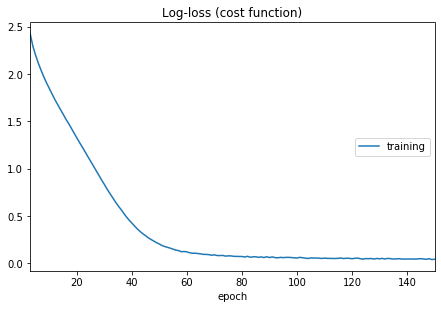

Log-loss (cost function):
training   (min:    0.041, max:    3.062, cur:    0.043)


In [0]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
from livelossplot.keras import PlotLossesCallback
import tensorflow  as tf


"""path = get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')"""
print("Loading text data...")
text = io.open('eminem.txt', encoding='utf-8').read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)*2, activation=tf.nn.relu))
model.add(Dense(len(chars)*4, activation=tf.nn.relu))
model.add(Dense(len(chars), activation=tf.nn.softmax))


opt = RMSprop(lr=0.001)
optimizer = opt
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

histoty = model.fit(x, y,
          batch_size=128,
          epochs=150,
          callbacks=[PlotLossesCallback()]
          )
          


In [0]:
histoty

In [0]:
model.save("model_500epoch.h5")

In [0]:
from keras.models import load_model

In [0]:
new_model = load_model("model_500epoch.h5")

In [0]:
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               95744     
_________________________________________________________________
dense_4 (Dense)              (None, 58)                7482      
Total params: 103,226
Trainable params: 103,226
Non-trainable params: 0
_________________________________________________________________


In [0]:
on_epoch_end()


----- diversity: 0.2
----- Generating with seed: "Hey baby
d need each other
or maybe you just needHey baby to tell

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


s sayd cause
that's do with cacidin' toon't
re's gud, you mut it me bis mr just stie, i'm somed
do i so probite at hope
so live!!
i'm lead smadhald be copeach i'm thist to be i do sit som brows
i'm a like om buy go on your know with me
and is wrose't leep comps
don't me every dave a to tele me
"you moph my nigga to doust me whit with a gothin' rot no to
you cause they beew it's nortin'
the
----- diversity: 0.5
----- Generating with seed: "Nigga
d need each other
or maybe you just needNigga to tell am?
it's just to bitely aind pf i fuck you the wald be crownet to a bug

and every navry happin', the seme dougs
down't the never a am whould no you stiel to beed me
who ever if i on't some to you
you ail you can't said of my this
i'm a didin' toong, do to tell all shooch
(o somethrs in yourssolave!
hit me just beepir, i'min't? getsen i'll keen i dod and i to thaniwa, i hat was fuck my th
----- diversity: 1.0
----- Generating with seed: "85 cents
d need each other
or maybe you just need85 cen

In [0]:
def on_epoch_end():
    # Function invoked at end of each epoch. Prints generated text.
    print()
    #print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        generated += input('----- Generating with seed: "' )
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [0]:
txt_gen = on_epoch_end(1,_)

TypeError: ignored

In [0]:
model_yaml = model.to_yaml()

In [0]:
yaml_file.write

NameError: ignored

In [0]:
import pyyaml

ModuleNotFoundError: ignored

In [0]:
with open('model500epochs.yaml', "w") as yaml_file:
  yaml_file.write(model_yaml)

In [0]:
model_yaml = model.to_yaml()

In [0]:
model.save_weights("model500epochwights.h5")

In [0]:
PlotLossesCallback()

In [0]:
on_epoch_end(1, _)


----- Generating text after Epoch: 1
----- diversity: 0.2
----- Generating with seed: "see i'm just like you in a way
i never k"
see i'm just like you in a way
i never knew i'd ugter heef on you hat no men
i seel ke mim on, kill our kill of on the benn call, heed theen autor
oo the hell on your tonnat
you dender monger the ther on you
no not ley like luredre croppbess the kinke
from she-outckersuplerentered me? healis fuedst an the fuct
a wit't even brince, i'm the, wathout whit whis? babguun andaund snit me shers
and llagse
sally did
i just the full my, dight wa
----- diversity: 0.5
----- Generating with seed: "see i'm just like you in a way
i never k"
see i'm just like you in a way
i never knew i'd ugttreke't get witl biters muth on the torent hiw her it and the nouse orgous and artustt slim shit mess
a judd, slimm now you seom won't loke shoot
coue thou so it me sonit , ned, all peelin' this ist
and i lake i may the fuck you that i leated wit that i got, i'm so i was hawh
toe veall